# Project Part 1
## Question 1
### Imports and Data Wrangling

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq

ois = pd.read_excel("./data/IR Data.xlsx", sheet_name = 'OIS', usecols = ["Tenor", "Product", "Rate"])

In [48]:
#tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '7y', '10y', '15y', '20y', '30y']
tenors = ois["Tenor"]

# Define a function to convert tenor strings to years
def tenor_to_years(tenor):
    if 'm' in tenor:
        return int(tenor.replace('m', '')) / 12
    elif 'y' in tenor:
        return int(tenor.replace('y', ''))
    else:
        return None

# Convert each tenor to years
ois["years"] = [tenor_to_years(tenor) for tenor in tenors]

# Add place holder for Discount Factors and cumsum of discount factors
ois[['f', 'cumsum_df','df']] = np.nan
ois.head(2)

,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.0025,0.5,NaN,NaN,NaN
1,1y,OIS,0.0030,1.0,NaN,NaN,NaN


### Solve for year 1 Discount Factor
Use the swap formula where we consider a par swap as the following:
$$
\sum_{i=1}^{n} D(0, T_i) \times \Delta_{i-1} \times L(T_{i-1}, T_i) = 1 - D(0, T_n) \\
\sum_{i=1}^{n} D(0, T_i) \times \Delta_{i-1} \times L(T_{i-1}, T_i) - (1 - D(0, T_n))= 0 \tag{1}
$$
Equation (1) can be a function of the unknown discount factor and can be used as objective function. After using Solver to find the root of equation (1), this root is the Discount Factor(df) for that year.

### get f for 0.5 year


In [49]:
f_0 = 360 * ((0.5*.0025+1)**(1/180)-1)
ois.at[0,'f'] = f_0

In [50]:
ois.head(2)

,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.0025,0.5,0.002498,NaN,NaN
1,1y,OIS,0.0030,1.0,NaN,NaN,NaN


In [51]:
def payer_ois_swap_1y(f_1, f_0, ois_1y):
    """
    Return PV of payer swap i.e. PV of fixed leg minus PV of floating leg 
    FOR FIRST YEAR ONLY
    paramters:
        f_0: zero rate 0 to .5 years
        f_1: zero rate .5 to 1 years
    """
    D_1 = 1/((1+f_0/360)**180 * (1+f_1/360)**180)

    fix_leg = D_1 * ois_1y
    flt_leg = D_1 * (1/D_1 - 1)

    return fix_leg - flt_leg
    
guess = 0.99

f_1 = fsolve(payer_ois_swap_1y, 
                         guess, 
                         args=(ois.at[0, 'f'],
                               ois.at[1, 'Rate']))[0]
ois.at[1, 'f'] = f_1
ois.at[1, 'df'] = 1/((1+f_0/360)**180 * (1+f_1/360)**180)
ois.cumsum_df = ois.df.cumsum()
ois.head()

,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.00250,0.5,0.002498,NaN,NaN
1,1y,OIS,0.00300,1.0,0.003493,0.997009,0.997009
2,2y,OIS,0.00325,2.0,NaN,NaN,NaN
3,3y,OIS,0.00335,3.0,NaN,NaN,NaN
4,4y,OIS,0.00350,4.0,NaN,NaN,NaN


In [52]:
years = [i for i in range(1,30)]
ois = ois.merge(pd.DataFrame({"years": years}),
                   how='outer')
ois.head(10)

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_66929/536065093.py:2: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  ois = ois.merge(pd.DataFrame({"years": years}),


,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.00250,0.5,0.002498,NaN,NaN
1,1y,OIS,0.00300,1.0,0.003493,0.997009,0.997009
2,2y,OIS,0.00325,2.0,NaN,NaN,NaN
3,3y,OIS,0.00335,3.0,NaN,NaN,NaN
4,4y,OIS,0.00350,4.0,NaN,NaN,NaN
5,5y,OIS,0.00360,5.0,NaN,NaN,NaN
6,NaN,NaN,NaN,6.0,NaN,NaN,NaN
7,7y,OIS,0.00400,7.0,NaN,NaN,NaN
8,NaN,NaN,NaN,8.0,NaN,NaN,NaN
9,NaN,NaN,NaN,9.0,NaN,NaN,NaN


### Solve for 2y to 5y

In [53]:
def D(t,df_ois, f_t):
    """
    Return discount factor
    FOR SECOND YEAR ONWARDS only
    parameters:
        t: maturity in years
        f: zero rate in annual terms for the latest year
    """
    D = 1
    D *= 1/((1+df_ois.at[0,'f'] /360)**180 * (1+df_ois.at[1,'f']/360)**180) #instantiate with 1y DF

    for i in range(2,int(t+1)):  # loop year 2 to year t
        f_i = ois.set_index('years')['f'].get(i, f_t)
        if pd.isna(f_i):        # assign the latest f_t if no f value in table
            f_i = f_t           # wrong since earlier periods with gaps will still take the latest value
        D *= 1/((1+f_i/360)**360)       # multiply each year's discount factor
        
    return D

# D(2.0,ois,.00350275)

In [54]:
def payer_ois_swap_2y(f_n, df_ois, T):
    """
    Return PV of payer swap i.e. PV of fixed leg minus PV of floating leg 
    FOR SECOND YEAR ONWARDS
    paramters:
        f_n: zero rate n-1 to n years
        df_ois: DataFrame of OIS and f values
        T: maturity of swap
    """
    if T <2:
        return "only for 2 year onwards"
    fix_leg = 0
    flt_leg = 0
    cumsum_df = 0
    # compute for 1y df 
    D1 = 1/((1+df_ois.at[0,'f'] /360)**180 * (1+df_ois.at[1,'f']/360)**180)
    flt_leg += D1 * (1/D1-1)
    cumsum_df += D1

    for i in range(2,int(T+1)):
        f_i = ois.set_index('years')['f'].get(i, f_n)
        if pd.isna(f_i):        # if there is no f value then assign the latest f
            f_i = f_n
        Di = D(i,ois,f_i)
        # for year 2 onwards add the df to the counters
        flt_leg +=  Di * ((1+f_i/360)**360-1)
        cumsum_df += Di
    
    fix_leg = cumsum_df * df_ois.loc[df_ois['years']==i,'Rate'].values[0] 

    return flt_leg-fix_leg

# payer_ois_swap_2y(.0025, ois, 2)

In [55]:
ois.head()

,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.00250,0.5,0.002498,NaN,NaN
1,1y,OIS,0.00300,1.0,0.003493,0.997009,0.997009
2,2y,OIS,0.00325,2.0,NaN,NaN,NaN
3,3y,OIS,0.00335,3.0,NaN,NaN,NaN
4,4y,OIS,0.00350,4.0,NaN,NaN,NaN


In [56]:
ois

,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.00250,0.5,0.002498,NaN,NaN
1,1y,OIS,0.00300,1.0,0.003493,0.997009,0.997009
2,2y,OIS,0.00325,2.0,NaN,NaN,NaN
3,3y,OIS,0.00335,3.0,NaN,NaN,NaN
4,4y,OIS,0.00350,4.0,NaN,NaN,NaN
5,5y,OIS,0.00360,5.0,NaN,NaN,NaN
6,NaN,NaN,NaN,6.0,NaN,NaN,NaN
7,7y,OIS,0.00400,7.0,NaN,NaN,NaN
8,NaN,NaN,NaN,8.0,NaN,NaN,NaN
9,NaN,NaN,NaN,9.0,NaN,NaN,NaN


In [57]:
guess = 0.0035
iter_idx = ois.loc[~ois.Tenor.isna()].index[2:].values

for i in iter_idx:
    T = ois.loc[i,'years']
    f_i = fsolve(payer_ois_swap_2y, 
                            guess, 
                            args=(ois,
                                    T))[0]
    ois.at[i, 'f'] = f_i
    ois['f'] = ois['f'].bfill()
    # ois.at[i, 'df'] = D(i,ois,f_i)

    guess = f_i
    print(ois)

# fill 0.5 year
ois.at[0,'df'] = 1/(1+f_0/360)**180

ois.head(10)

   Tenor Product     Rate  years         f  cumsum_df        df
0     6m     OIS  0.00250    0.5  0.002498        NaN       NaN
1     1y     OIS  0.00300    1.0  0.003493   0.997009  0.997009
2     2y     OIS  0.00325    2.0  0.003495        NaN       NaN
3     3y     OIS  0.00335    3.0       NaN        NaN       NaN
4     4y     OIS  0.00350    4.0       NaN        NaN       NaN
5     5y     OIS  0.00360    5.0       NaN        NaN       NaN
6    NaN     NaN      NaN    6.0       NaN        NaN       NaN
7     7y     OIS  0.00400    7.0       NaN        NaN       NaN
8    NaN     NaN      NaN    8.0       NaN        NaN       NaN
9    NaN     NaN      NaN    9.0       NaN        NaN       NaN
10   10y     OIS  0.00450   10.0       NaN        NaN       NaN
11   NaN     NaN      NaN   11.0       NaN        NaN       NaN
12   NaN     NaN      NaN   12.0       NaN        NaN       NaN
13   NaN     NaN      NaN   13.0       NaN        NaN       NaN
14   NaN     NaN      NaN   14.0       N

,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.00250,0.5,0.002498,NaN,0.998752
1,1y,OIS,0.00300,1.0,0.003493,0.997009,0.997009
2,2y,OIS,0.00325,2.0,0.003495,NaN,NaN
3,3y,OIS,0.00335,3.0,0.003545,NaN,NaN
4,4y,OIS,0.00350,4.0,0.003946,NaN,NaN
5,5y,OIS,0.00360,5.0,0.003996,NaN,NaN
6,NaN,NaN,NaN,6.0,0.005003,NaN,NaN
7,7y,OIS,0.00400,7.0,0.005003,NaN,NaN
8,NaN,NaN,NaN,8.0,0.005680,NaN,NaN
9,NaN,NaN,NaN,9.0,0.005680,NaN,NaN


### Interpolate semi-annual DF and cumsum

In [58]:

1/((1+0.003495/360)**360)

0.9965111173095044

In [59]:
ois.loc[:1, 'period_df'] = ois[:2].apply(lambda row: 1 / ((1 + row['f'] / 360) ** (180)), axis=1)
ois.loc[2:, 'period_df'] = ois[2:].apply(lambda row: 1 / ((1 + row['f'] / 360) ** (360)), axis=1)
ois['df'] = ois['period_df'].cumprod()
ois['cumsum_df'] = ois['df'].cumsum()
ois.drop(columns=['period_df'], inplace=True)

ois.tail(20)

,Tenor,Product,Rate,years,f,cumsum_df,df
11,NaN,NaN,NaN,11.0,0.006024,11.731830,0.950236
12,NaN,NaN,NaN,12.0,0.006024,12.676359,0.944529
13,NaN,NaN,NaN,13.0,0.006024,13.615215,0.938857
14,NaN,NaN,NaN,14.0,0.006024,14.548434,0.933218
15,15y,OIS,0.00500,15.0,0.006024,15.476047,0.927614
16,NaN,NaN,NaN,16.0,0.006026,16.398087,0.922040
17,NaN,NaN,NaN,17.0,0.006026,17.314588,0.916500
18,NaN,NaN,NaN,18.0,0.006026,18.225581,0.910994
19,NaN,NaN,NaN,19.0,0.006026,19.131102,0.905520
20,20y,OIS,0.00525,20.0,0.006026,20.031181,0.900080


In [60]:
ois.tail()

,Tenor,Product,Rate,years,f,cumsum_df,df
26,NaN,NaN,NaN,26.0,0.006028,25.319191,0.868106
27,NaN,NaN,NaN,27.0,0.006028,26.182081,0.862889
28,NaN,NaN,NaN,28.0,0.006028,27.039784,0.857703
29,NaN,NaN,NaN,29.0,0.006028,27.892332,0.852548
30,30y,OIS,0.0055,30.0,0.006028,28.739756,0.847424


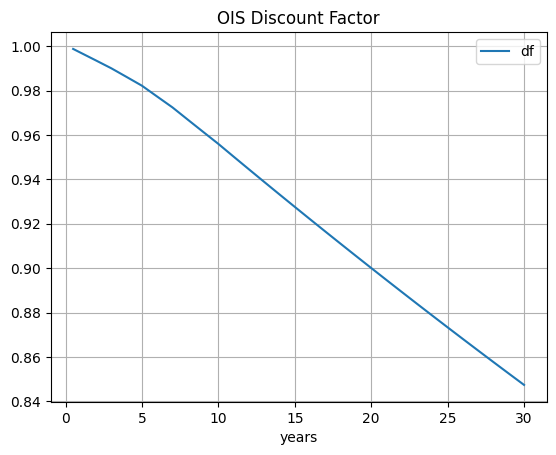

In [61]:
ois.plot(x='years',y='df')
plt.title("OIS Discount Factor")
plt.grid(True)
plt.show()

## Question 2
### Imports and Data Wrangling

In [62]:
irs = pd.read_excel("./data/IR Data.xlsx", sheet_name = 'IRS', usecols = ["Tenor", "Product", "Rate"])
# Convert each tenor to years
irs["years"] = [tenor_to_years(tenor) for tenor in tenors]

irs = irs.merge(ois[['years','f']],on='years',how='outer')
irs.rename(columns={"df": "ois_df"}, inplace=True)
years = [i for i in np.arange(1,30,.5)]
irs = irs.merge(pd.DataFrame({"years": years}), how='outer')
irs["f"] = irs.f.bfill()
irs['period_df'] = 1/(1+irs['f']/360)**180
irs['ois_df'] = irs['period_df'].cumprod()
irs.drop(columns=['period_df'],inplace=True)
irs["libor_df"] = np.nan

irs.head()

,Tenor,Product,Rate,years,f,ois_df,libor_df
0,6m,LIBOR,0.025,0.5,0.002498,0.998752,NaN
1,1y,IRS,0.028,1.0,0.003493,0.997009,NaN
2,NaN,NaN,NaN,1.5,0.003495,0.995268,NaN
3,2y,IRS,0.030,2.0,0.003495,0.993531,NaN
4,NaN,NaN,NaN,2.5,0.003545,0.991771,NaN


### solve for IRS swap with OIS discount factors

$$
\sum^N_{i=1} D_o(0,T_i) \times \Delta_i \times IRS = \sum^N_{i=1} D_o(0,T_i) \times L(T_{i-1}, T_i) \\
\sum^N_{i=1} D_o(0,T_i) \times \Delta_i \times IRS - \sum^N_{i=1} D_o(0,T_i) \times L(T_{i-1}, T_i)  = 0 \\ 
\sum^N_{i=1} D_o(0,T_i) \times \Delta_i \times IRS - \sum^N_{i=1} D_o(0,T_i) 
\times \left[\frac{D(0,T_{i-1})-D(0,T_{i})}{D(0,T_{i})}\right]  = 0 \\ 
$$

where $L(T_{i-1}, T_i) = \left[\frac{D(0,T_{i-1})-D(0,T_{i})}{D(0,T_{i})}\right]$

First obtain LIBOR discount factor

In [63]:
irs.at[0,'libor_df'] = 1/(1+irs.at[0,'Rate']/2)

In [64]:
def payer_irs_swap(df, i, irs):
    """
    Return value of payer swap
    """
    irs1 = irs.copy()
    irs1.at[i,'libor_df'] = df
    irs1[['years','libor_df']] = irs1[['years','libor_df']].interpolate(method='linear')

    # fix_leg = cumsum_ois_df * 0.5 * IRS
    cumsum_ois_df = irs1['ois_df'].iloc[:i+1].sum()
    irs_rate = irs1.at[i,'Rate']
    fix_leg = cumsum_ois_df * 0.5 * irs_rate

    # float leg = D_o(j) * (D(j-1)-D(j))/D(j) for j in range i
    float_leg = irs1.at[0,'ois_df'] * (1-irs1.at[0,'libor_df']) / irs1.at[0,'libor_df']
    for j in range(1,i+1):
        float_leg += irs1.at[j,'ois_df'] * (irs1.at[j-1,'libor_df']-irs1.at[j,'libor_df']) \
                                            / irs1.at[j,'libor_df']

    return float_leg - fix_leg

# collate list of indices with IRS swaps
idx_irs = irs[irs['Product'] == "IRS"].index[1:]
guess = .99

# iterate through years
for i in idx_irs:       # skip first index since already computed
        x = fsolve(payer_irs_swap,
                    guess,
                    args=(i,irs))[0]
        irs.at[i, 'libor_df'] = x
        guess = x                       # IMPORTANT to update guess, there is multiple roots
irs['libor_df'] = irs['libor_df'].interpolate(method='linear')

irs.head()

,Tenor,Product,Rate,years,f,ois_df,libor_df
0,6m,LIBOR,0.025,0.5,0.002498,0.998752,0.987654
1,1y,IRS,0.028,1.0,0.003493,0.997009,0.972496
2,NaN,NaN,NaN,1.5,0.003495,0.995268,0.957338
3,2y,IRS,0.030,2.0,0.003495,0.993531,0.942179
4,NaN,NaN,NaN,2.5,0.003545,0.991771,0.926330


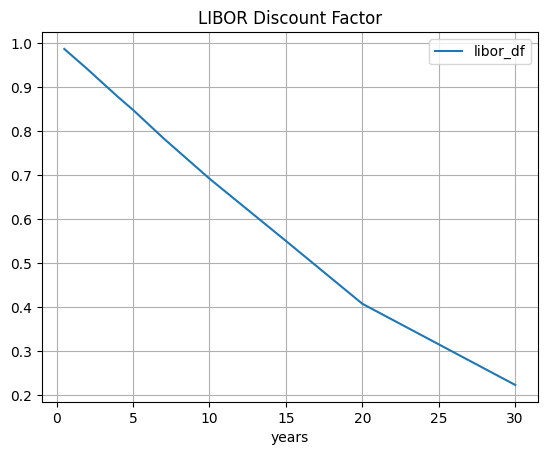

In [65]:
irs.plot(x='years',y='libor_df')
plt.title("LIBOR Discount Factor")
plt.grid(True)
plt.show()

## Question 3
Solving for FRA will be similar to swaps, however the starting points will differ
**LIBOR forward swaps**
$$
\sum^N_{i=s+1} D_o(0,T_i) \times \Delta_i \times IRS_{forward} - \sum^N_{i=s+1} D_o(0,T_i) 
\times \left[\frac{D(0,T_{i-1})-D(0,T_{i})}{D(0,T_{i})}\right]  = 0 \\ 
$$
**OIS forward swaps**
$$\begin{aligned}
OIS_{forward} &= 
            \frac{D_o(0,T_{s})-D_o(0,T_{N})}
                    {\Delta_i  \sum^N_{i=s+1}D_o(0,T_{i})} \\
            &= 
            \frac{D_o(0,T_{s})-D_o(0,T_{N})}
                    {\Delta_i  \left[ \sum^s_{i=0}D_o(0,T_{i}) - \sum^N_{i=0}D_o(0,T_{i}) \right]} \\
\end{aligned}$$

where $s$ is the start of the rate agreement and N is maturity.

Create a new df for annual OIS cumsum df

In [66]:
def payer_irs_fwd_swap(fwd_swap_rate, start=1, tenor=1, irs=irs):
    """
    Return value of forward payer swap starting from year 1 ahead
    Parameters:
        fwd_swap_rate:
        start: in years, 
        i: tenor in years, 
        irs: Dataframe of IRS rates, libor/OIS df
    """
    # fix_leg = cumsum_ois_df * 0.5 * IRS
    # for forward starting, deduct the starting period DF
    cumsum_ois_df = irs.loc[irs['years'] <= start+tenor, 'ois_df'].sum() \
                        - irs.loc[irs['years'] <= start, 'ois_df'].sum()
    fix_leg = cumsum_ois_df * 0.5 * fwd_swap_rate

    # float leg = D_o(j) * (D(j-1)-D(j))/D(j) for j in range i
    float_leg = 0
    for j in range(int(start*2),int((start+tenor)*2)):
        float_leg += irs.at[j,'ois_df'] * (irs.at[j-1,'libor_df']-irs.at[j,'libor_df']) \
                                            / irs.at[j,'libor_df']

    return fix_leg - float_leg

# payer_irs_fwd_swap(.032007, 1, 1, irs)

In [67]:
# instantiate Forward Swap Rate table
fsr = pd.DataFrame({'start' : [1]*5 + [5]*5 + [10]*5,
                          'tenor' : [1,2,3,5,10]*3, 
                          'f_irs': [np.nan]*15, 
                          'f_ois': [np.nan]*15})

# iterate through table and get FRA
for idx, row in fsr.iterrows():
    start = row['start']
    tenor = row['tenor']
    tenor_days = 360*tenor
    L = 1

    # compute forward Libor
    fsr.at[idx, 'f_irs'] = fsolve(payer_irs_fwd_swap,
                                      guess,
                                      args=(start,
                                            tenor,
                                            irs))
    
    # compute forward OIS
    for i in range(int(start+1), int(start+tenor+1)):     
        f = ois.loc[ois.years == i].f.values[0]
        L *= (1+f/360)**360
    fsr.at[idx, 'f_ois'] = 360*(L**(1/tenor_days)-1)

fsr

,start,tenor,f_irs,f_ois
0,1,1,0.031922,0.003495
1,1,2,0.033217,0.003520
2,1,3,0.033982,0.003662
3,1,5,0.035238,0.003997
4,1,10,0.038419,0.004805
5,5,1,0.039274,0.005003
6,5,2,0.040075,0.005003
7,5,3,0.040072,0.005228
8,5,5,0.041093,0.005409
9,5,10,0.043634,0.005716


---

#### Compute values for next parts

In [68]:
fsr.to_csv('./data/fsr.csv', index=False)
ois.to_csv('./data/ois.csv', index=False)
irs.to_csv('./data/irs.csv', index=False)

In [69]:
for start, tenor in zip([2,8], [10,10]):
    tenor_days = 360*tenor
    L = 1
    # compute forward Libor
    par_rate = fsolve(payer_irs_fwd_swap,
                        guess,
                        args=(start,
                            tenor,
                            irs))
    print(f"far rate: {par_rate}")
    # compute forward OIS
    for i in range(int(start+1), int(start+tenor+1)):     
        f = ois.loc[ois.years == i].f.values[0]
        L *= (1+f/360)**360
    ois_df = 360*(L**(1/tenor_days)-1)
    print(f"ois_df {ois_df}")

far rate: [0.0396344]
ois_df 0.005057884633759002
far rate: [0.04871141]
ois_df 0.005955791373679631
